# Clustering Geocoded Tweets of 2012 London Olympic Games
by [Talha Oz](http://talhaoz.com) (submitted as GeoSocial Class Assignment #4)

#### Q1
The question asks to identify *clusters of tweets* as a broad concept, and does not state a particular domain to cluster on, i.e. one can cluster the tweets solely based on their geogprahic properties, or alternatively can color them based on their sentiment polarity. Here, I chose the former viewpoint, where the clusters are formed only according to their location.

I first compute the distances between every unique pair of tweeting points using `Vincenty` algorithm implemented in `geopy` library because default implementations of clustering algorithms in `sklearn` package use `Euclidean distance` as their similarity metric. Since `Vincenty` algorithm measures near-actual distances given geographical coordinate points, this is a better metric than `Euclidean` approach.

I initially tried `DBSCAN` algorithm, where I only got a few clusters and too many unclustered points. Since the locations of the tweeps are scattered around several countries, and there is a high variation of density of points in our dataset, this density based clustering approach apparently not fitted well to our case.

As I do not want to set number of clusters before running the algorithm, rather want algorithm to choose the appropriate number of clusters from the dataset, I used `Affinity Propagation (AP)` algorithm implemented in `sklearn`as the details of the implemention is discussed [here](http://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)

#### Q2
1. Read in the csv file into a dataframe and assign column names (as there is no header row in the provided CSV file).
2. Group the tweets by their coordinates [i.e., (lat,lon) pairs]:
 1. Average the sentiment polarities
 2. Count number of tweets in each group
3. As a result of groupby operation 5729 tweets are reduced to 1185 locations
 1. Location with the highest tweet count is found to be London city center, where 1778 of 5729 tweets originated from.
4. I created distance matrix using `pairwise_distances` in `sklearn.metrics.pairwise`, and `vincenty` in `geopy.distance`. And described this matrix to have better grasp of the dataset. Average distance between any two points is 116 miles and the maximum distant points are located 938 miles away from each other.
5. I used `X.max() - X` to transform distance matrix to similarity matrix 
 1. This transformation technique revealed better results than suggested 1/(1+X) method.
 2. `preference` parameter in AffinityPropagation algorithm defaults to median, so inversion does not change it. Along with `damping factor` they control number of examplers used (and hence # of clusters), as default values gave satisfactory results, I did not change it.


#### Q3
* 64 clusters are detected. I created plots to see the cluster sizes
 * first plot shows the sizes of every individual cluster
 * second plot is a histogram, shows the distribution of cluster sizes among 20 bins
* Every point is clustered.
* Time complexity of the algorithm (in big O notation) is O(N^2 T), i.e. quadratic to the number of input N (points), and T is a constant (number of iterations, in our case 200). Memory complexity of the algorithm is also O(N^2).
* I think the algorithm did a pretty good job in clustering the locations (based on my eyeball test).

#### Q4
Folium (Leaflet.js) library is used for interactive mapping where locations are marked in circles whose radii are proportional to tweets originated from the same lat,lon. Moreover, five tile sets are [offered](http://folium.readthedocs.org/en/latest/) by Folium. I used 'Mapbox Bright' as I found it to have the least distractive colors (simply white) which will not lead to any biases for the colors of the clusters (e.g. green forests make it hard to see the markers on top of them). As the colormap, I use qualitative palette ([Dark2 with 8 colors](http://jiffyclub.github.io/palettable/colorbrewer/qualitative/#dark2_7)), as I believe that reflects the clusters best for this tileset.

Please see below, an interactive map is provided as the output of the last command

In [1]:
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from geopy.distance import vincenty
import numpy as np
import folium
from IPython.display import HTML
from itertools import cycle
%matplotlib inline

In [2]:
def vincenty_mi(p1,p2):
    """get two points and return their distance in miles"""
    return vincenty((p1[0],p1[1]),(p2[0],p2[1])).miles

In [3]:
df = pd.read_csv('Olympic_torch_2012_UK.csv',header=None,names=['twtime','lat','lon','sp'],parse_dates=[0])
df['cnt'] = 0
# average sp (sentiment polarities) and count tweets from the same lat/lon
df = pd.DataFrame(df.groupby(by=['lat','lon'],as_index=False).agg({'cnt':len,'sp':np.mean}))
print('Total number of tweets:',df['cnt'].sum())
print('Number of unique locations:',len(df))
print('Location with the highest tweet count (London city center):')
df[df.cnt == df['cnt'].max()]

Total number of tweets: 5729
Number of unique locations: 1185
Location with the highest tweet count (London city center):


,lat,lon,cnt,sp
364,51.506325,-0.127144,1778,0.762092


In [4]:
# this takes about 1 min 14 secs (measured by %timeit -n1 -r1)...
X = pairwise_distances(df[['lat','lon']],metric=vincenty_mi)
pd.Series(X.flatten()).describe()

count    1404225.000000
mean         161.534136
std          116.156397
min            0.000000
25%           71.512331
50%          142.112504
75%          222.983646
max          937.977691
dtype: float64

In [5]:
# convert distance matrix to similarity
X = X.max()-X

In [6]:
# feed in the precomputed similarity matrix to the clustering algorithm
# db = DBSCAN(eps=15,min_samples=10,metric='precomputed').fit_predict(X) # eps=0.3, min_samples=10
db = AffinityPropagation(affinity='precomputed').fit_predict(X)
df['cluster'] = db
df.head() # every point now has a cluster value

,lat,lon,cnt,sp,cluster
0,46.126862,3.429990,1,0.000000,0
1,46.211401,2.209360,11,0.636364,0
2,46.289863,3.060979,1,3.000000,0
3,46.707375,0.874530,1,0.000000,1
4,46.914511,1.160956,1,0.000000,1


In [7]:
#let's group by clusters and print the number of points in each cluster
grouped = df.groupby(by='cluster',as_index=False)
print('size of each cluster:',[{k:len(v)} for k,v in grouped.groups.items()])

size of each cluster: [{0: 4}, {1: 2}, {2: 5}, {3: 14}, {4: 3}, {5: 7}, {6: 8}, {7: 14}, {8: 17}, {9: 16}, {10: 22}, {11: 8}, {12: 14}, {13: 12}, {14: 15}, {15: 10}, {16: 16}, {17: 23}, {18: 22}, {19: 16}, {20: 17}, {21: 32}, {22: 178}, {23: 63}, {24: 25}, {25: 17}, {26: 15}, {27: 24}, {28: 22}, {29: 18}, {30: 6}, {31: 12}, {32: 10}, {33: 14}, {34: 16}, {35: 7}, {36: 30}, {37: 12}, {38: 17}, {39: 10}, {40: 21}, {41: 19}, {42: 13}, {43: 11}, {44: 35}, {45: 26}, {46: 33}, {47: 24}, {48: 16}, {49: 44}, {50: 9}, {51: 1}, {52: 12}, {53: 10}, {54: 8}, {55: 10}, {56: 8}, {57: 21}, {58: 10}, {59: 15}, {60: 19}, {61: 8}, {62: 12}, {63: 7}]


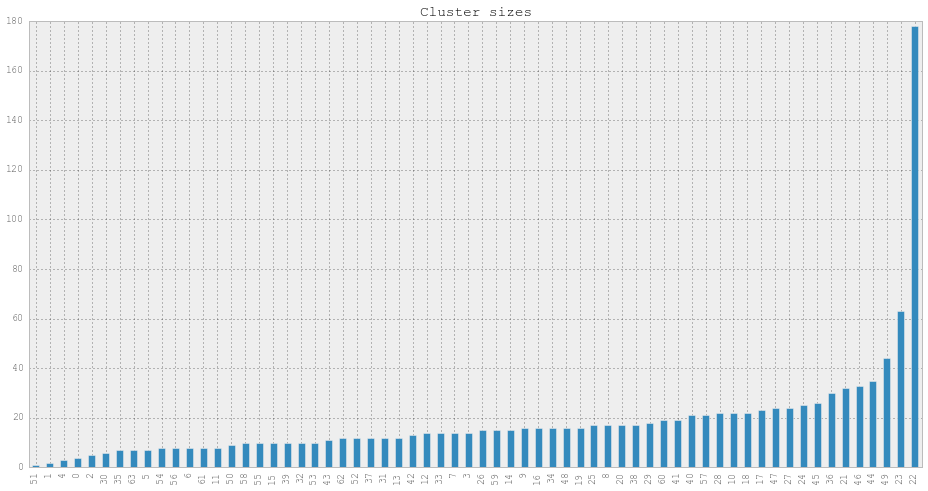

In [8]:
#let's plot the clusters in ordered by cluster sizes (x: ID of cluster, y: number of points)
pd.options.display.mpl_style = 'default'
clusters = pd.Series([len(v) for v in grouped.groups.values()]).order()
clusters.plot(kind='bar',figsize = (16,8),title='Cluster sizes');

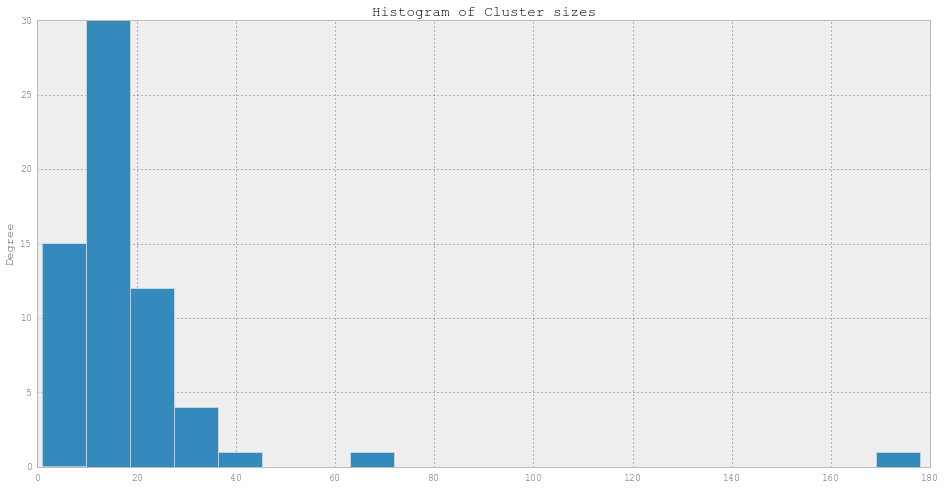

In [9]:
#let's see the cluster sizes in a histogram of 20 bins
clusters.plot(kind='hist',bins=20,figsize = (16,8), title='Histogram of Cluster sizes');

In [10]:
# among others, this colormap in this palette looks the best
from palettable.colorbrewer.qualitative import Dark2_8 as colmap
#from palettable.tableau import Tableau_20 as colmap
colors = {}
for i,c in enumerate(set(df['cluster'])):
    i = i % colmap.number
    colors.update({c:colmap.hex_colors[i]})

In [11]:
uk = folium.Map(location=[53.3, -3.5], zoom_start=6,  width=991, height = 1000, tiles='Mapbox Bright')
df.apply(lambda x: uk.circle_marker(location=[x['lat'], x['lon']],
                 radius=x['cnt'],
                 popup=str(x['cluster']), line_color=colors[x['cluster']],
                 fill_color=colors[x['cluster']], fill_opacity=0.2),
         axis=1);
uk.create_map(path='uk.html')
HTML('<iframe src="uk.html" style="width: 100%; height: 1000px; border: none"></iframe>')